In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [1]:
#!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



## Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.  
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/](https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/)

This spreadsheet consists of three worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, &ldquo;Prices&rdquo;, and a series of different years of food &ldquo;Expenditures&rdquo;.

Each worksheet has the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Malawi&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should
have one column for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data allow, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



### From Sheet to DataFrame to Result Object



With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [2]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

In [3]:
x = read_sheets('https://docs.google.com/spreadsheets/d/1POplhyd44h-Zt8jMhXa2FGAzS051TPoLa2xMlmvVLU0/edit#gid=1822599829',sheet='Expenditures')
#x = x.set_index(['i','t','m','j']).squeeze().unstack('j')
rural = x.where(x['m']=="Mainland Rural").dropna()
urban = x.where(x['m']=="Mainland Other Urban").dropna()
capital = x.where(x['m']=="Dar Es Salaam").dropna()

rural = rural.pivot_table(values='value_purchase', index=['i','t','m'], columns='j', aggfunc='first').reset_index()
urban = urban.pivot_table(values='value_purchase', index=['i','t','m'], columns='j', aggfunc='first').reset_index()
capital = capital.pivot_table(values='value_purchase', index=['i','t','m'], columns='j', aggfunc='first').reset_index()

household = read_sheets('https://docs.google.com/spreadsheets/d/1POplhyd44h-Zt8jMhXa2FGAzS051TPoLa2xMlmvVLU0/edit#gid=1822599829',sheet="HH Characteristics")
household.columns.name = 'k'
household.set_index(['i','t','m'],inplace=True)

# x may have duplicate columns
rural = rural.groupby('j',axis=1).sum()
rural = rural.replace(0,np.nan) # Replace zeros with missing
rural = rural.set_index(['i','t','m'])
rural = rural.apply(pd.to_numeric, errors='coerce')

urban = urban.groupby('j',axis=1).sum()
urban = urban.replace(0,np.nan) # Replace zeros with missing
urban = urban.set_index(['i','t','m'])
urban = urban.apply(pd.to_numeric, errors='coerce')

capital = capital.groupby('j',axis=1).sum()
capital = capital.replace(0,np.nan) # Replace zeros with missing
capital = capital.set_index(['i','t','m'])
capital = capital.apply(pd.to_numeric, errors='coerce')

# Take logs of expenditures; call this y
log_rural = np.log(rural)
log_urban = np.log(urban)
log_capital = np.log(capital)

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


Adapted from example: <br>
&nbsp;&nbsp;&nbsp;&nbsp;Two different $x$: "rural" and "urban" <br>
&nbsp;&nbsp;&nbsp;&nbsp;Subsequently two different $y$: "log_rural" and "log_urban" <br>
&nbsp;&nbsp;&nbsp;&nbsp;$d$ is now "household"

This gives a dataframe of household characteristics $d$ with a simple structure.



In [4]:
rural

j                              Beef  Bottled beer  Bread  Butter  \
i    t       m                                                     
1    2008-09 Mainland Rural  2500.0           NaN    NaN     NaN   
     2010-11 Mainland Rural     NaN           NaN    NaN     NaN   
     2012-13 Mainland Rural  2000.0           NaN    NaN     NaN   
     2014-15 Mainland Rural     NaN           NaN    NaN     NaN   
     2019-20 Mainland Rural  2500.0           NaN    NaN     NaN   
...                             ...           ...    ...     ...   
999  2012-13 Mainland Rural     NaN           NaN    NaN     NaN   
9992 2012-13 Mainland Rural     NaN           NaN    NaN     NaN   
9996 2012-13 Mainland Rural     NaN           NaN    NaN     NaN   
9997 2012-13 Mainland Rural     NaN           NaN    NaN     NaN   
9999 2012-13 Mainland Rural     NaN           NaN    NaN     NaN   

j                            Canned milk/milk powder  \
i    t       m                                         
1    2008-09 Mainland Rural                      NaN   
     2010-11 Mainland Rural                      NaN   
     2012-13 Mainland Rural                      NaN   
     2014-15 Mainland Rural                      NaN   
     2019-20 Mainland Rural                      NaN   
...                                              ...   
999  2012-13 Mainland Rural                      NaN   
9992 2012-13 Mainland Rural                      NaN   
9996 2012-13 Mainland Rural                      NaN   
9997 2012-13 Mainland Rural                      NaN   
9999 2012-13 Mainland Rural                      NaN   

j                            Canned, dried and wild vegetables  \
i    t       m                                                   
1    2008-09 Mainland Rural                                NaN   
     2010-11 Mainland Rural                                NaN   
     2012-13 Mainland Rural                                NaN   
     2014-15 Mainland Rural                                NaN   
     2019-20 Mainland Rural                                NaN   
...                                                        ...   
999  2012-13 Mainland Rural                                NaN   
9992 2012-13 Mainland Rural                                NaN   
9996 2012-13 Mainland Rural                                NaN   
9997 2012-13 Mainland Rural                                NaN   
9999 2012-13 Mainland Rural                                NaN   

j                            Cassava dry/flour  Cassava fresh  Chicken  \
i    t       m                                                           
1    2008-09 Mainland Rural                NaN            NaN      NaN   
     2010-11 Mainland Rural                NaN            NaN      NaN   
     2012-13 Mainland Rural                NaN            NaN      NaN   
     2014-15 Mainland Rural                NaN            NaN      NaN   
     2019-20 Mainland Rural                NaN            NaN      NaN   
...                                        ...            ...      ...   
999  2012-13 Mainland Rural                NaN            NaN      NaN   
9992 2012-13 Mainland Rural                NaN            NaN      NaN   
9996 2012-13 Mainland Rural             5000.0            NaN      NaN   
9997 2012-13 Mainland Rural                NaN            NaN      NaN   
9999 2012-13 Mainland Rural                NaN            NaN      NaN   

j                            Citrus fruits  ...  Wheat, barley, other grains  \
i    t       m                              ...                                
1    2008-09 Mainland Rural            NaN  ...                          NaN   
     2010-11 Mainland Rural            NaN  ...                          NaN   
     2012-13 Mainland Rural            NaN  ...                          NaN   
     2014-15 Mainland Rural            NaN  ...                          NaN   
     2019-20 Mainland Rural            NaN  ...                          NaN   
... 

In [5]:
household.head()

k                         Females 00-03  Females 04-08  Females 09-13  \
i t       m                                                             
1 2012-13 Mainland Rural            0.0            0.0            0.0   
  2014-15 Mainland Rural            0.0            0.0            0.0   
2 2014-15 Mainland Rural            0.0            0.0            0.0   
4 2012-13 Mainland Rural            1.0            1.0            0.0   
  2014-15 Mainland Rural            0.0            2.0            0.0   

k                         Females 14-18  Females 19-30  Females 31-50  \
i t       m                                                             
1 2012-13 Mainland Rural            0.0            0.0            0.0   
  2014-15 Mainland Rural            0.0            0.0            0.0   
2 2014-15 Mainland Rural            0.0            1.0            0.0   
4 2012-13 Mainland Rural            0.0            1.0            0.0   
  2014-15 Mainland Rural            0.0            1.0            0.0   

k                         Females 51-99  Males 00-03  Males 04-08  \
i t       m                                                         
1 2012-13 Mainland Rural            1.0          0.0          0.0   
  2014-15 Mainland Rural            1.0          0.0          0.0   
2 2014-15 Mainland Rural            0.0          1.0          0.0   
4 2012-13 Mainland Rural            0.0          0.0          0.0   
  2014-15 Mainland Rural            0.0          1.0          0.0   

k                         Males 09-13  Males 14-18  Males 19-30  Males 31-50  \
i t       m                                                                    
1 2012-13 Mainland Rural          0.0          0.0          2.0          0.0   
  2014-15 Mainland Rural          0.0          0.0          1.0          1.0   
2 2014-15 Mainland Rural          0.0          0.0          1.0          0.0   
4 2012-13 Mainland Rural          0.0          0.0          0.0          1.0   
  2014-15 Mainland Rural          0.0          0.0          0.0          1.0   

k                         Males 51-99  log HSize  Rural  
i t       m                                              
1 2012-13 Mainland Rural          1.0   1.386294    1.0  
  2014-15 Mainland Rural          1.0   1.386294    1.0  
2 2014-15 Mainland Rural          0.0   1.098612    1.0  
4 2012-13 Mainland Rural          0.0   1.386294    1.0  
  2014-15 Mainland Rural          0.0   1.609438    1.0

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [6]:
log_rural.head()

j                             Beef  Bottled beer  Bread  Butter  \
i t       m                                                       
1 2008-09 Mainland Rural  7.824046           NaN    NaN     NaN   
  2010-11 Mainland Rural       NaN           NaN    NaN     NaN   
  2012-13 Mainland Rural  7.600902           NaN    NaN     NaN   
  2014-15 Mainland Rural       NaN           NaN    NaN     NaN   
  2019-20 Mainland Rural  7.824046           NaN    NaN     NaN   

j                         Canned milk/milk powder  \
i t       m                                         
1 2008-09 Mainland Rural                      NaN   
  2010-11 Mainland Rural                      NaN   
  2012-13 Mainland Rural                      NaN   
  2014-15 Mainland Rural                      NaN   
  2019-20 Mainland Rural                      NaN   

j                         Canned, dried and wild vegetables  \
i t       m                                                   
1 2008-09 Mainland Rural                                NaN   
  2010-11 Mainland Rural                                NaN   
  2012-13 Mainland Rural                                NaN   
  2014-15 Mainland Rural                                NaN   
  2019-20 Mainland Rural                                NaN   

j                         Cassava dry/flour  Cassava fresh  Chicken  \
i t       m                                                           
1 2008-09 Mainland Rural                NaN            NaN      NaN   
  2010-11 Mainland Rural                NaN            NaN      NaN   
  2012-13 Mainland Rural                NaN            NaN      NaN   
  2014-15 Mainland Rural                NaN            NaN      NaN   
  2019-20 Mainland Rural                NaN            NaN      NaN   

j                         Citrus fruits  ...  Wheat, barley, other grains  \
i t       m                              ...                                
1 2008-09 Mainland Rural            NaN  ...                          NaN   
  2010-11 Mainland Rural            NaN  ...                          NaN   
  2012-13 Mainland Rural            NaN  ...                          NaN   
  2014-15 Mainland Rural            NaN  ...                          NaN   
  2019-20 Mainland Rural            NaN  ...                          NaN   

j                         Wild birds and insects  Wine and spirits  \
i t       m                                                          
1 2008-09 Mainland Rural                     NaN               NaN   
  2010-11 Mainland Rural                     NaN               NaN   
  2012-13 Mainland Rural                     NaN               NaN   
  2014-15 Mainland Rural                     NaN               NaN   
  2019-20 Mainland Rural                     NaN               NaN   

j                         Yams/cocoyams  bread  eggs  salt  sugar  sugarcane  \
i t       m                                                                    
1 2008-09 Mainland Rural            NaN    NaN   NaN   NaN    NaN        NaN   
  2010-11 Mainland Rural            NaN    NaN   NaN   NaN    NaN        NaN   
  2012-13 Mainland Rural            NaN    NaN   NaN   NaN    NaN        NaN   
  2014-15 Mainland Rural            NaN    NaN   NaN   NaN    NaN        NaN   
  2019-20 Mainland Rural            NaN    NaN   NaN   NaN    NaN        NaN   

j                         sweets  
i t       m                       
1 2008-09 Mainland Rural     NaN  
  2010-11 Mainland Rural     NaN  
  2012-13 Mainland Rural     NaN  
  2014-15 Mainland Rural     NaN  
  2019-20 Mainland Rural     NaN  

[5 rows x 67 columns]

In [7]:
log_urban.head()

,,j,Beef,Bottled beer,Bread,Butter,Canned milk/milk powder,"Canned, dried and wild vegetables",Cassava dry/flour,Cassava fresh,Chicken,Citrus fruits,...,Wheat (flour),Wild birds and insects,Wine and spirits,Yams/cocoyams,bread,eggs,salt,sugar,sugarcane,sweets
i,t,m,,,,,,,,,,,,,,,,,,,,,
10003,2012-13,Mainland Other Urban,8.160518,NaN,NaN,NaN,NaN,NaN,NaN,5.298317,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,2012-13,Mainland Other Urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.991465,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10005,2012-13,Mainland Other Urban,9.952278,NaN,NaN,NaN,NaN,NaN,NaN,6.684612,8.517193,4.60517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10006,2012-13,Mainland Other Urban,8.160518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10008,2012-13,Mainland Other Urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.214608,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
log_capital.head()

,,j,Beef,Bottled beer,Bread,Butter,Canned milk/milk powder,"Canned, dried and wild vegetables",Cassava dry/flour,Cassava fresh,Chicken,Citrus fruits,...,"Wheat, barley, other grains",Wild birds and insects,Wine and spirits,Yams/cocoyams,bread,eggs,salt,sugar,sugarcane,sweets
i,t,m,,,,,,,,,,,,,,,,,,,,,
10009,2012-13,Dar Es Salaam,9.392662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.991465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10086,2012-13,Dar Es Salaam,NaN,NaN,7.863267,NaN,NaN,NaN,NaN,8.006368,NaN,7.003065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10094,2012-13,Dar Es Salaam,NaN,NaN,6.907755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10104,2012-13,Dar Es Salaam,9.798127,NaN,8.294050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10107,2012-13,Dar Es Salaam,8.922658,NaN,NaN,NaN,7.600902,NaN,NaN,NaN,7.600902,8.411833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There may be some goods that very few people consume&#x2014;too few to estimate demand reliably.   We have code to deal with this.  You can play with the `min_obs` parameter&#x2014;the larger it is, the more foods will be dropped.



In [9]:
from cfe.estimation import drop_columns_wo_covariance

log_rural = drop_columns_wo_covariance(log_rural,min_obs=30)
log_urban = drop_columns_wo_covariance(log_urban,min_obs=30)
log_capital = drop_columns_wo_covariance(log_capital,min_obs=30)

Missing dependencies for OracleDemands.


Now, we want the $d$ and $y$ dataframes to have rows that line up:



In [10]:
use_rural = log_rural.index.intersection(household.index)
log_rural = log_rural.loc[use_rural,:]
household_rural = household.loc[use_rural,:]

use_urban = log_urban.index.intersection(household.index)
log_urban = log_urban.loc[use_urban,:]
household_urban = household.loc[use_urban,:]

use_capital = log_capital.index.intersection(household.index)
log_capital = log_capital.loc[use_capital,:]
household_capital = household.loc[use_capital,:]

## Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
So, a first step is to turn our dataframe for `y` into a series, so we can put it on the left-hand side of this regression.  Then we need to make our dataframe $d$ conform:



In [11]:
log_rural = log_rural.stack()
log_urban = log_urban.stack()
log_capital = log_capital.stack()

household_rural_stacked = household_rural.stack()
household_urban_stacked = household_urban.stack()
household_capital_stacked = household_capital.stack()

In [12]:
# Check that indices are in right places!
assert log_rural.index.names == ['i','t','m','j']
assert log_urban.index.names == ['i','t','m','j']
assert log_capital.index.names == ['i','t','m','j']

assert household_rural_stacked.index.names == ['i','t','m','k']
assert household_urban_stacked.index.names == ['i','t','m','k']
assert household_capital_stacked.index.names == ['i','t','m','k']

### Basic Estimation



Just one line to set up the regression:



In [13]:
# Add this line of code to get rid of repeat indices
idx_rural = np.unique(household_rural_stacked.index.values, return_index = True)[1] 
household_rural_stacked = household_rural_stacked.iloc[idx_rural]

idx_urban = np.unique(household_urban_stacked.index.values, return_index = True)[1] 
household_urban_stacked = household_urban_stacked.iloc[idx_urban]

idx_capital = np.unique(household_capital_stacked.index.values, return_index = True)[1] 
household_capital_stacked = household_capital_stacked.iloc[idx_capital]

In [14]:
from cfe import Regression

result_rural = Regression(y=log_rural,d=household_rural_stacked)
result_urban = Regression(y=log_urban,d=household_urban_stacked)
result_capital = Regression(y=log_capital,d=household_capital_stacked)

And then one line to predict expenditures and estimate most of the things we need:



In [15]:
result_rural.predicted_expenditures()

i    t        m               j                                       
1    2012-13  Mainland Rural  Beef                                        3194.127301
                              Cassava fresh                               1866.523757
                              Citrus fruits                                691.813413
                              Coconuts                                    1774.616943
                              Cooking oil                                 1112.275198
                                                                             ...     
995  2012-13  Mainland Rural  Ripe bananas                                 405.180349
                              Soft drinks                                 1458.456317
                              Spinach, cabbage, other green vegetables     564.903847
                              Sweet potatoes                              1063.287675
                              Tea (dry)                              

In [16]:
result_urban.predicted_expenditures()

i     t        m                     j                                       
1009  2012-13  Mainland Other Urban  Beef                                        4021.698277
                                     Cassava fresh                               1200.786453
                                     Citrus fruits                                494.517814
                                     Coconuts                                    1969.952401
                                     Cooking oil                                 1214.670815
                                                                                    ...     
9939  2014-15  Mainland Other Urban  Ripe bananas                                 546.015679
                                     Soft drinks                                 1180.019422
                                     Spinach, cabbage, other green vegetables     596.906992
                                     Sweet potatoes                               897

In [17]:
result_capital.predicted_expenditures()

i     t        m              j                                       
1037  2012-13  Dar Es Salaam  Beef                                        7634.785556
                              Citrus fruits                               3432.689054
                              Coconuts                                    3582.776041
                              Cooking oil                                 2886.932726
                              Dried/salted/canned fish                    3218.353947
                                                                             ...     
992   2012-13  Dar Es Salaam  Ripe bananas                                1963.423666
                              Soft drinks                                 2763.131391
                              Spinach, cabbage, other green vegetables    1471.993243
                              Sweet potatoes                              1471.172119
                              Tea (dry)                              

Now we can compare predicted log expenditures with actual:



<IPython.core.display.Javascript object>


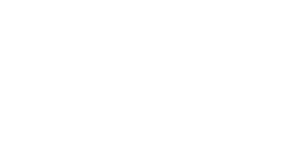

<AxesSubplot:xlabel='yhat', ylabel='y'>

In [18]:
%matplotlib notebook
df_rural = pd.DataFrame({'y':log_rural,'yhat':result_rural.get_predicted_log_expenditures()})
df_rural.plot.scatter(x='yhat',y='y')

<IPython.core.display.Javascript object>


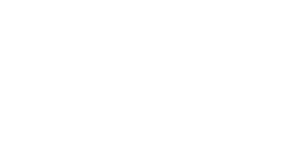

<AxesSubplot:xlabel='yhat', ylabel='y'>

In [19]:
%matplotlib notebook
df_urban = pd.DataFrame({'y':log_urban,'yhat':result_urban.get_predicted_log_expenditures()})
df_urban.plot.scatter(x='yhat',y='y')

<IPython.core.display.Javascript object>


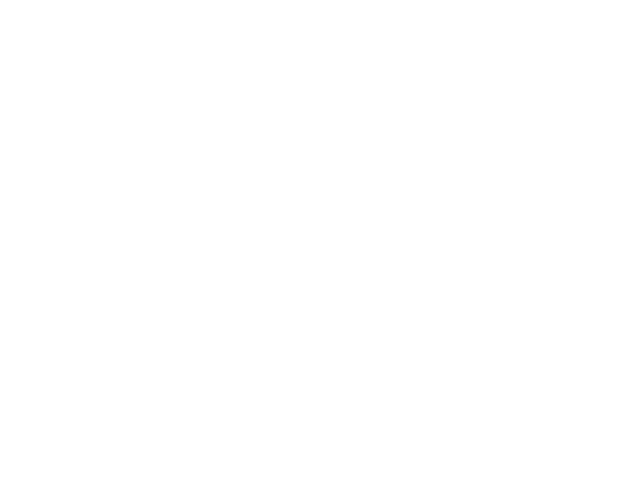

<AxesSubplot:xlabel='yhat', ylabel='y'>

In [20]:
%matplotlib notebook
df_capital = pd.DataFrame({'y':log_capital,'yhat':result_capital.get_predicted_log_expenditures()})
df_capital.plot.scatter(x='yhat',y='y')

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



### Parameters



#### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.



In [21]:
result_rural.get_beta().sort_values()

j
Cassava fresh                                            0.149389
Maize (flour)                                            0.153971
Irish potatoes                                           0.268086
Sweet potatoes                                           0.284773
Goat meat                                                0.330513
Tea (dry)                                                0.330865
Soft drinks                                              0.342690
Plantains                                                0.376571
Coconuts                                                 0.383230
Groundnuts                                               0.390270
Peas, beans, lentils and other pulses                    0.394395
Rice (husked)                                            0.427673
Beef                                                     0.444977
Dried/salted/canned fish                                 0.446299
Fresh fish                                               0.486351
Cooking 

In [22]:
result_urban.get_beta().sort_values()

j
Maize (flour)                                            0.141471
Tea (dry)                                                0.172998
Pasta                                                    0.228784
Cassava fresh                                            0.279721
Sweet potatoes                                           0.309235
Peas, beans, lentils and other pulses                    0.371869
Plantains                                                0.390284
Cooking oil                                              0.394499
Fresh milk                                               0.402689
Soft drinks                                              0.411397
Groundnuts                                               0.416080
Dried/salted/canned fish                                 0.417341
Beef                                                     0.438168
Rice (husked)                                            0.439327
Pastries                                                 0.453165
Irish po

In [23]:
result_capital.get_beta().sort_values()

j
Maize (flour)                                            -0.069812
Tea (dry)                                                 0.008569
Pastries                                                  0.130796
Peas, beans, lentils and other pulses                     0.202262
Pasta                                                     0.232715
Rice (husked)                                             0.277141
Sweet potatoes                                            0.282542
Cooking oil                                               0.284164
Coconuts                                                  0.291577
Groundnuts                                                0.311065
Plantains                                                 0.317328
Dried/salted/canned fish                                  0.334597
Other spices                                              0.359494
Onions, tomatoes, carrots, green pepper, other viungo     0.359723
Beef                                                      0.

Here we use a plot to visualize, with confidence intervals.



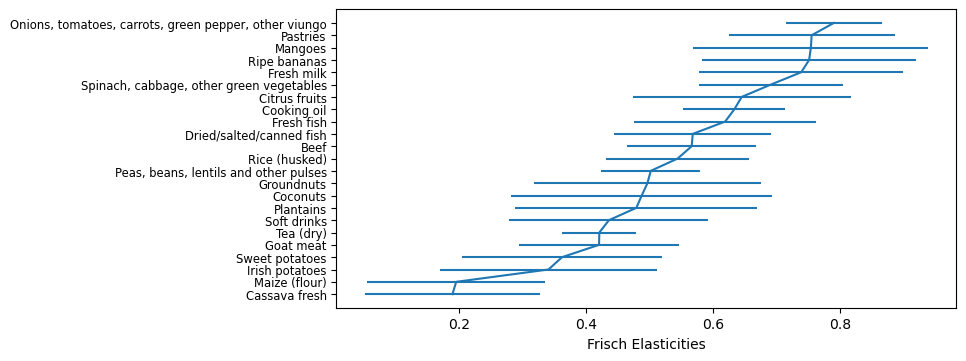

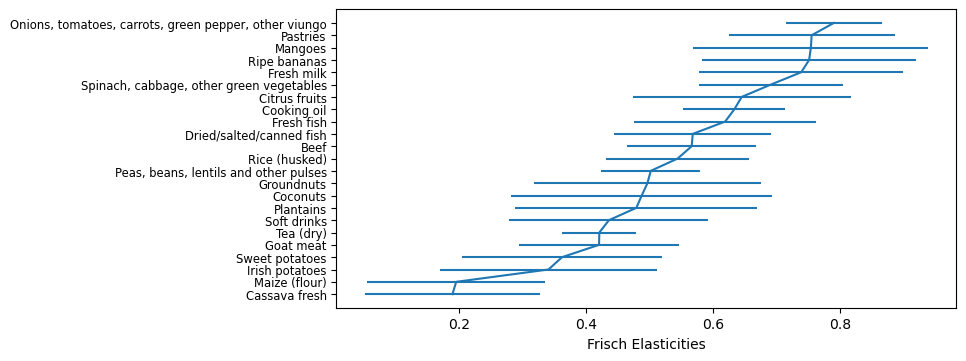

In [61]:
result_rural.graph_beta()

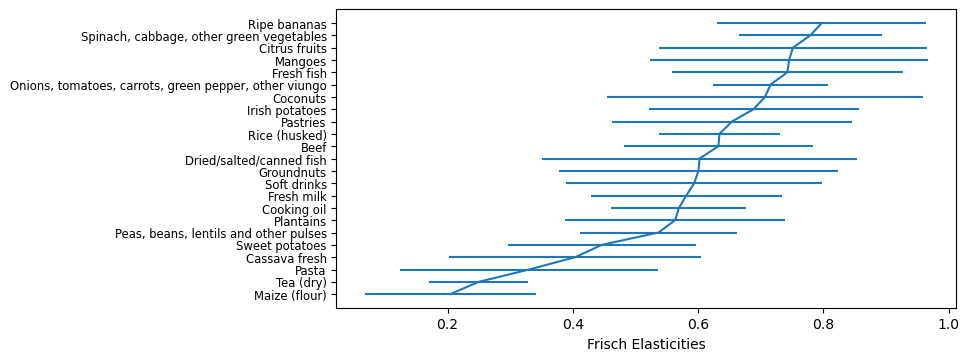

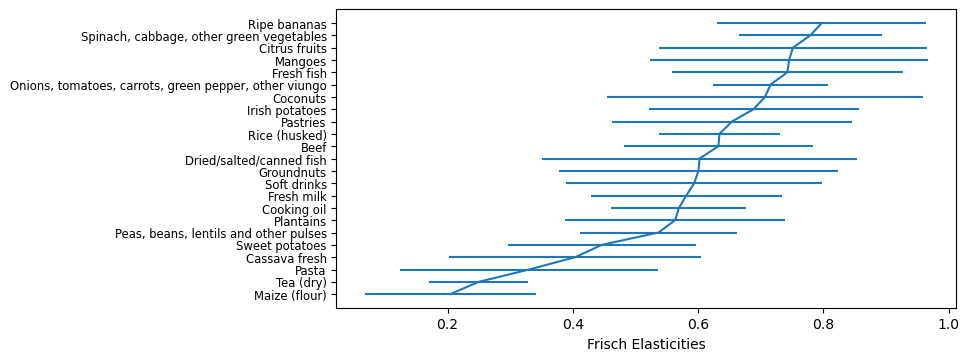

In [62]:
result_urban.graph_beta()

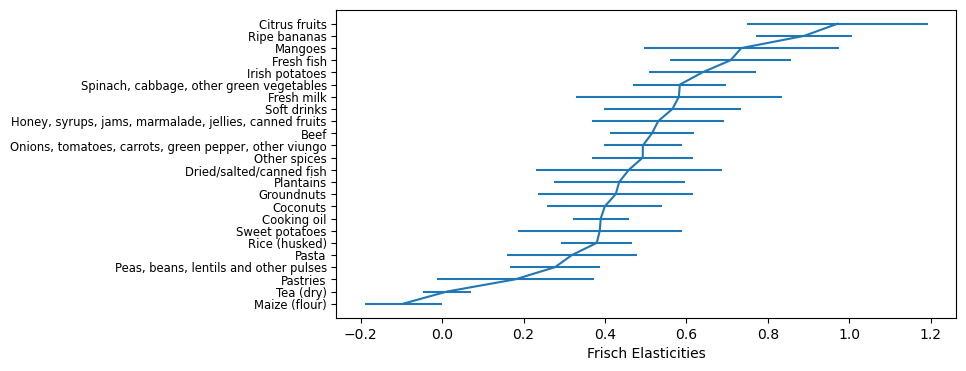

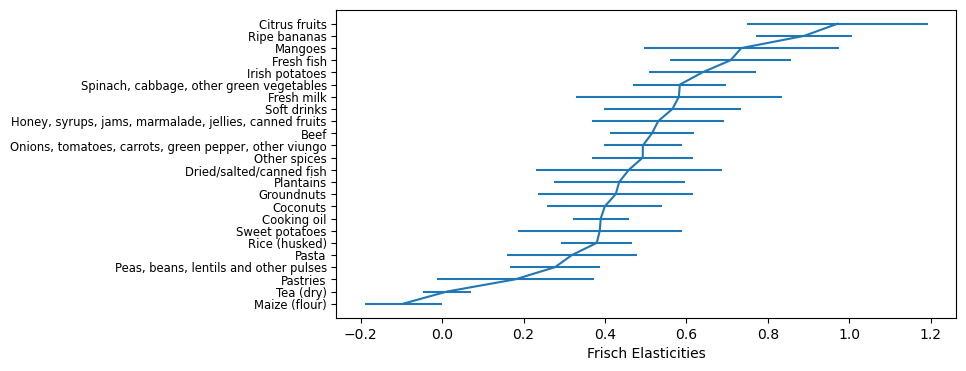

In [63]:
result_capital.graph_beta()

#### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [27]:
result_rural.gamma

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Rural,Constant
j,,,,,,,,,,,,,,,,,
Beef,-0.018440,0.048819,0.048971,0.062807,0.119483,0.124571,0.094546,-0.033053,0.050153,0.018923,0.084398,0.072538,0.208029,0.161689,-0.149373,-0.176001,-0.176001
Cassava fresh,0.083658,0.052565,0.123656,0.059618,0.090549,0.028143,0.263954,0.051091,-0.032318,0.057977,0.118254,0.030221,0.081467,0.197885,-0.129222,-0.150555,-0.150555
Citrus fruits,-0.038002,-0.025017,0.004748,-0.023600,0.014169,-0.017547,-0.072908,-0.094709,-0.086576,0.083760,-0.001671,0.047769,0.142132,0.128331,0.336206,-0.383528,-0.383528
Coconuts,-0.059189,-0.054400,-0.103124,-0.074861,-0.069377,-0.143443,0.033634,-0.051213,-0.065418,-0.101570,-0.055377,-0.047945,-0.124207,-0.001707,0.214394,-0.042197,-0.042197
Cooking oil,-0.025104,0.017079,0.027734,0.073772,0.135137,0.120466,-0.011802,-0.057470,0.016351,0.033958,0.070607,0.089003,0.131912,0.060583,-0.032357,-0.158668,-0.158668
Dried/salted/canned fish,0.046267,-0.035822,0.000961,-0.031363,0.093871,0.109375,-0.025473,-0.024031,-0.016465,0.044263,0.051326,0.042375,0.054933,0.049500,0.256215,-0.357958,-0.357958
Fresh fish,0.014765,0.011333,0.061849,0.046047,0.135353,0.128557,0.064090,-0.012975,-0.038122,-0.026483,0.018787,0.053420,0.152530,0.064439,0.132822,-0.298018,-0.298018
Fresh milk,-0.049938,-0.016027,-0.030848,0.031492,0.101952,0.013400,0.006400,-0.011000,-0.043562,-0.008987,0.077231,-0.001319,0.115020,0.047540,0.262893,-0.374811,-0.374811
Goat meat,-0.006462,0.033967,0.097078,0.060911,0.087537,0.101930,0.119278,-0.026725,0.071004,0.024450,-0.045795,0.166562,0.032463,0.033961,0.091178,-0.315348,-0.315348


In [28]:
result_urban.gamma

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Rural,Constant
j,,,,,,,,,,,,,,,,,
Beef,-0.062446,-0.070234,-0.047866,0.057020,0.037527,0.022328,-0.022268,-0.131537,-0.036409,-0.034651,0.034747,0.026917,0.097951,0.075051,0.469048,-0.049368,-0.925565
Cassava fresh,-0.030969,0.017064,0.198623,-0.142137,-0.038257,-0.099343,0.006000,-0.057398,0.034578,0.133997,0.011945,0.081791,0.132429,0.174437,0.247707,0.068626,-0.579367
Citrus fruits,0.101916,-0.053898,0.020085,0.032518,0.026241,-0.108647,-0.080976,-0.130944,-0.106177,-0.060583,0.092986,0.036449,0.087493,-0.036565,0.466370,-0.057683,-0.861518
Coconuts,0.154450,0.100530,0.005071,0.147144,0.051676,0.135947,0.229035,0.223906,0.181686,0.232459,0.247778,0.168781,0.252699,0.247442,-0.604623,-0.134914,-0.087060
Cooking oil,-0.024251,0.012375,-0.042553,0.100712,0.136153,0.097609,-0.013766,-0.140247,-0.011094,0.019086,0.072477,0.011797,0.064573,0.010182,0.333991,-0.110605,-0.773651
Dried/salted/canned fish,-0.010761,0.040564,0.035838,0.008096,0.073746,0.108574,0.051929,-0.006805,-0.025515,0.022964,0.031200,0.035252,0.153312,0.074962,0.233139,-0.192896,-0.671161
Fresh fish,0.035297,0.019673,0.034617,0.085765,0.251329,0.250201,-0.025665,-0.110067,-0.079843,0.067850,-0.044045,0.041629,0.112580,-0.078317,0.339995,-0.242246,-1.001715
Fresh milk,0.242759,0.043181,0.027383,0.078727,0.218970,-0.095444,-0.267630,0.100069,-0.020493,0.202184,0.073498,0.104836,0.085342,0.161175,-0.027777,-0.274591,-0.477209
Groundnuts,0.196227,0.077056,0.117840,0.063410,0.068866,0.083393,-0.049924,0.067051,0.078138,0.116186,0.150915,0.119473,0.195646,0.290788,-0.394456,-0.053823,-0.004158


In [29]:
result_capital.gamma

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Rural,Constant
j,,,,,,,,,,,,,,,,,
Beef,-0.063178,0.049240,-0.010731,0.113784,0.026154,-0.134615,-0.022182,0.059335,0.072488,-0.097050,0.024636,0.045117,0.048839,0.159714,0.495174,-0.248581,-0.947701
Citrus fruits,-0.068366,-0.150060,-0.065433,0.071435,0.035236,0.046401,-0.017843,0.008257,-0.056478,0.071757,-0.006018,0.007911,0.066832,-0.226263,0.577411,-0.040465,-1.035887
Coconuts,0.102761,0.042579,0.011225,0.093762,0.041464,-0.005029,0.018105,0.013925,0.121876,0.049790,0.024037,0.077870,0.102856,0.014572,0.302965,-0.050763,-0.838301
Cooking oil,0.015812,0.006301,-0.042803,0.105036,0.066989,-0.064126,0.012532,0.054568,0.091353,0.021029,0.039923,0.033747,0.117332,0.101056,0.286441,-0.032956,-0.714605
Dried/salted/canned fish,0.161514,0.033615,0.173450,0.002653,0.023559,0.021552,-0.049606,-0.168220,0.094601,-0.083317,-0.180785,0.191090,0.024082,-0.121630,0.390113,0.027244,-0.797717
Fresh fish,-0.093718,-0.024423,-0.184728,0.077265,0.046418,-0.007272,-0.015176,-0.113163,0.056300,-0.078323,-0.133056,0.011886,0.123429,0.143946,0.557979,-0.303280,-0.989602
Fresh milk,-0.088032,-0.040045,0.047146,0.004914,-0.003410,-0.066916,-0.171901,-0.065161,0.139404,0.103405,-0.118333,-0.075492,-0.080011,-0.006361,0.466951,0.628352,-0.754477
Groundnuts,-0.136061,-0.116851,-0.072603,0.219464,-0.222651,-0.121010,0.120290,-0.129199,0.135589,-0.210862,-0.221238,-0.063528,0.139864,0.106734,0.761618,0.148284,-1.059163
"Honey, syrups, jams, marmalade, jellies, canned fruits",-0.140036,-0.015897,-0.035656,0.176983,0.061913,-0.122026,-0.154596,-0.047045,-0.038205,-0.083035,-0.096774,0.012252,0.197851,-0.022772,0.473869,-0.641243,-0.930856


<AxesSubplot:>

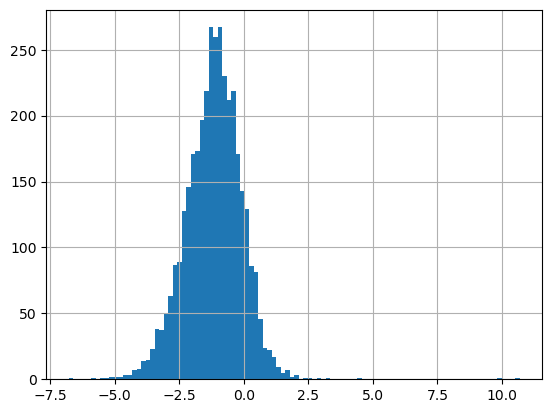

In [30]:
%matplotlib inline
result_rural.w.hist(bins=100)

<AxesSubplot:>

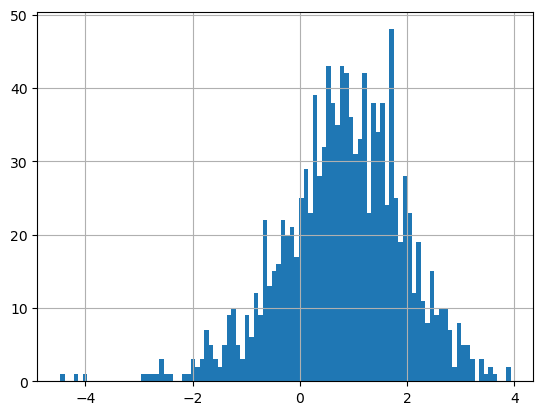

In [31]:
%matplotlib inline
result_urban.w.hist(bins=100)

<AxesSubplot:>

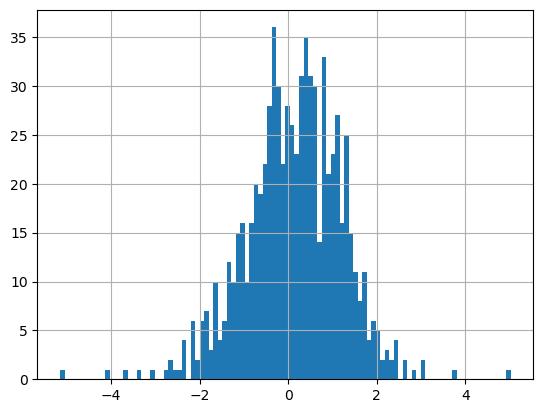

In [32]:
%matplotlib inline
result_capital.w.hist(bins=100)

### Saving Result



You can save the estimated result, using something like



In [33]:
#result.to_pickle('my_estimates.pickle')

You can subsequently load this using



In [34]:
import cfe
#result = cfe.regression.read_pickle('my_estimates.pickle')

# Nutritional Adequacy of Diet

In [35]:
consumption = read_sheets('https://docs.google.com/spreadsheets/d/1eRq1SbS5xTBkTzpjxLQLAKQ-j4o5UVp4mhHZSsn8K0M/edit#gid=1674215724',sheet='Consumption')
consumption.columns = ['i','t','m','j','units','quant_ttl_consume']

consumption_rural = consumption.where(consumption['m']=="Mainland Rural").dropna()
consumption_rural['j'] = consumption_rural['j'].str.lower()
consumption_rural = consumption_rural.pivot_table(values='quant_ttl_consume', index=['i','t','m'], columns='j', aggfunc='first').reset_index()
consumption_rural = consumption_rural.drop([''],axis=1)
consumption_rural = consumption_rural.set_index(['i','t','m'])

consumption_urban = consumption.where(consumption['m']=="Mainland Other Urban").dropna()
consumption_urban['j'] = consumption_urban['j'].str.lower()
consumption_urban = consumption_urban.pivot_table(values='quant_ttl_consume', index=['i','t','m'], columns='j', aggfunc='first').reset_index()
consumption_urban = consumption_urban.drop([''],axis=1)
consumption_urban = consumption_urban.set_index(['i','t','m'])

consumption_capital = consumption.where(consumption['m']=="Dar Es Salaam").dropna()
consumption_capital['j'] = consumption_capital['j'].str.lower()
consumption_capital = consumption_capital.pivot_table(values='quant_ttl_consume', index=['i','t','m'], columns='j', aggfunc='first').reset_index()
consumption_capital = consumption_capital.drop([''],axis=1)
consumption_capital = consumption_capital.set_index(['i','t','m'])

Key available for students@eep153.iam.gserviceaccount.com.


In [36]:
nutrition = read_sheets('https://docs.google.com/spreadsheets/d/18EuF3OLGDB6-hb9PToJzDMfyvN8cDqEpzPmQl9leJBU/edit#gid=1385026268',sheet='For Use in Code')
nutrition['Item name'] = nutrition['Item name'].str.lower()
nutrition = nutrition.sort_values(by=['Item name']).drop(['Value'],axis=1).set_index('Item name').transpose()

# Reset nutrition columns to match the consumption columns
nutrition.columns = ['canned, dried and wild vegetables','beef','bottled beer','bread','butter','x','canned milk/milk powder','nuts','cassava dry/flour','cassava fresh','chicken','coconuts','coffee and cocoa','x','cooking oil','x','cricket','dried/salted/canned fish','eggs','fish','fresh milk','goat meat','groundnuts','honey, syrups, jams, marmalade, jellies, canned fruits','x','irish potatoes','x','local beer','x','x','maize (flour)','maize (grain)','maize (green, cob)','x','mangoes','millet and sorghum (flour)','millet and sorghum (grain)','onions, tomatoes, carrots, green pepper, other viungo','citrus fruits','x','x','x','other starches','pork','x','rice (husked)','rice (paddy)','ripe bananas','salt','spinach, cabbage, other green vegetables','sugar','sugarcane','seeds and nut products','sweet potatoes','sweets','tea (dry)','x','wheat (flour)','x','yams/cocoyams']
nutrition = nutrition.drop(columns=['x'])
nutrition = nutrition.reindex(sorted(nutrition.columns), axis=1).fillna(0).astype(float)

Key available for students@eep153.iam.gserviceaccount.com.


In [37]:
# Drops all columns not in both dataframes
consumption_rural = consumption_rural.drop([col for col in consumption_rural if col not in nutrition.columns.values],axis=1).fillna(0).astype(float)
consumption_urban = consumption_urban.drop([col for col in consumption_urban if col not in nutrition.columns.values],axis=1).fillna(0).astype(float)
consumption_capital = consumption_capital.drop([col for col in consumption_capital if col not in nutrition.columns.values],axis=1).fillna(0).astype(float)

In [38]:
consumption_rural.head(5)

j                         beef  bottled beer  bread  butter  \
i t       m                                                   
1 2008-09 Mainland Rural   1.0           0.0    0.0     0.0   
  2010-11 Mainland Rural   0.0           0.0    0.0     0.0   
  2012-13 Mainland Rural   1.0           0.0    0.0     0.0   
  2014-15 Mainland Rural   0.0           0.0    0.0     0.0   
  2019-20 Mainland Rural   0.5           0.0    0.0     0.0   

j                         canned milk/milk powder  \
i t       m                                         
1 2008-09 Mainland Rural                      0.0   
  2010-11 Mainland Rural                      0.0   
  2012-13 Mainland Rural                      0.0   
  2014-15 Mainland Rural                      0.0   
  2019-20 Mainland Rural                      0.0   

j                         canned, dried and wild vegetables  \
i t       m                                                   
1 2008-09 Mainland Rural                                0.5   
  2010-11 Mainland Rural                                0.5   
  2012-13 Mainland Rural                                0.6   
  2014-15 Mainland Rural                                0.0   
  2019-20 Mainland Rural                                0.0   

j                         cassava dry/flour  cassava fresh  chicken  \
i t       m                                                           
1 2008-09 Mainland Rural                0.0            0.0      0.0   
  2010-11 Mainland Rural                0.0            0.0      0.0   
  2012-13 Mainland Rural                0.0            0.0      0.0   
  2014-15 Mainland Rural                0.0            0.0      1.4   
  2019-20 Mainland Rural                0.0            2.4      1.3   

j                         citrus fruits  ...  salt  seeds and nut products  \
i t       m                              ...                                 
1 2008-09 Mainland Rural            0.0  ...  0.08                     0.0   
  2010-11 Mainland Rural            0.0  ...  0.50                     0.0   
  2012-13 Mainland Rural            0.0  ...  0.10                     0.0   
  2014-15 Mainland Rural            0.0  ...  0.25                     0.0   
  2019-20 Mainland Rural            0.0  ...  0.20                     0.0   

j                         spinach, cabbage, other green vegetables  sugar  \
i t       m                                                                 
1 2008-09 Mainland Rural                                       0.8   0.50   
  2010-11 Mainland Rural                                       0.9   1.75   
  2012-13 Mainland Rural                                       0.0   0.00   
  2014-15 Mainland Rural                                       2.4   1.00   
  2019-20 Mainland Rural                                       1.8   0.25   

j                         sugarcane  sweet potatoes  sweets  tea (dry)  \
i t       m                                                              
1 2008-09 Mainland Rural        0.0             0.0     0.0      0.009   
  2010-11 Mainland Rural        0.0             0.0     0.0      0.030   
  2012-13 Mainland Rural        0.0             0.0     0.0      0.000   
  2014-15 Mainland Rural        2.6             0.0     0.0      0.025   
  2019-20 Mainland Rural        0.0             0.6     0.0      0.012   

j                         wheat (flour)  yams/cocoyams  
i t       m                                             
1 2008-09 Mainland Rural            0.0            0.0  
  2010-11 Mainland Rural            0.0            0.0  
  2012-13 Mainland Rural            0.0            0.0  
  2014-15 Mainland Rural            2.0            0.0  
  2019-20 Mainland Rural            0.0            0.0  

[5 rows x 46 columns]

In [39]:
nutrition.head(5)

,beef,bottled beer,bread,butter,canned milk/milk powder,"canned, dried and wild vegetables",cassava dry/flour,cassava fresh,chicken,citrus fruits,...,salt,seeds and nut products,"spinach, cabbage, other green vegetables",sugar,sugarcane,sweet potatoes,sweets,tea (dry),wheat (flour),yams/cocoyams
energy kcal,323.0,41.0,274.0,876.0,496.0,23.0,314.0,160.0,167.0,47.0,...,0.0,588.0,23.0,387.0,26.0,74.0,479.0,1.0,399.0,97.0
protein g,24.9,0.3,8.0,0.3,26.3,8.5,2.6,1.4,24.5,0.9,...,0.0,26.4,3.0,0.0,0.0,1.2,4.2,0.0,13.7,2.1
vit a ug,0.0,0.0,0.0,925.0,407.0,146.0,14.0,1.0,27.0,8.0,...,0.0,7.0,819.0,0.0,0.0,1056.0,0.0,0.0,0.0,0.0
vit d ug,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vit e ug,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.2,0.0,0.0,...,0.0,2.0,1.0,0.0,0.0,4.0,0.3,0.0,0.0,5.0


In [40]:
rural_nutrition = consumption_rural.dot(nutrition.transpose())
urban_nutrition = consumption_urban.dot(nutrition.transpose())
capital_nutrition = consumption_capital.dot(nutrition.transpose())

In [41]:
rural_nutrition.head(5)

energy kcal  protein g  vit a ug  vit d ug  \
i t       m                                                            
1 2008-09 Mainland Rural      793.579     44.470     812.2       0.0   
  2010-11 Mainland Rural     6057.730    122.860    1097.1       0.0   
  2012-13 Mainland Rural     4916.300    127.850      87.6       0.0   
  2014-15 Mainland Rural    13909.585    429.376    6068.2      40.0   
  2019-20 Mainland Rural     4755.712    175.200    2231.1       0.0   

                          vit e ug  vit c mg  vit b6 mg  vit b12 ug     ca mg  \
i t       m                                                                     
1 2008-09 Mainland Rural     1.360     30.25      0.925        4.85   512.418   
  2010-11 Mainland Rural     9.550    220.18      5.075        9.70  2536.010   
  2012-13 Mainland Rural    12.250     30.40      4.070        1.90   150.140   
  2014-15 Mainland Rural    40.715     51.44     14.822       64.27  1483.990   
  2019-20 Mainland Rural     8.490    108.18      6.755       19.26  2442.024   

                             mg mg    fe mg   zn mg  
i t       m                                          
1 2008-09 Mainland Rural   162.378    5.858   5.125  
  2010-11 Mainland Rural   597.360   31.005  18.285  
  2012-13 Mainland Rural  1585.200   45.190  26.160  
  2014-15 Mainland Rural  2987.930  110.851  60.398  
  2019-20 Mainland Rural   710.824   35.385  22.545

In [42]:
rural_nutrition_compare = rural_nutrition.merge(household_rural,left_index=True,right_index=True)
rural_nutrition_compare = rural_nutrition_compare.drop(rural_nutrition_compare.iloc[:,12:],axis=1)

urban_nutrition_compare = urban_nutrition.merge(household_urban,left_index=True,right_index=True)
urban_nutrition_compare = urban_nutrition_compare.drop(urban_nutrition_compare.iloc[:,12:],axis=1)

capital_nutrition_compare = capital_nutrition.merge(household_capital,left_index=True,right_index=True)
capital_nutrition_compare = capital_nutrition_compare.drop(capital_nutrition_compare.iloc[:,12:],axis=1)

In [43]:
household_rural = household_rural.iloc[:,0:-2]
household_urban = household_urban.iloc[:,0:-2]
household_capital = household_capital.iloc[:,0:-2]

In [44]:
household_rural_size = household_rural.sum(axis=1).values
household_urban_size = household_urban.sum(axis=1).values
household_capital_size = household_capital.sum(axis=1).values

In [45]:
rural_nutrition_standardized = (rural_nutrition_compare.transpose()/household_rural_size).transpose()
urban_nutrition_standardized = (urban_nutrition_compare.transpose()/household_urban_size).transpose()
capital_nutrition_standardized = (capital_nutrition_compare.transpose()/household_capital_size).transpose()

In [46]:
avg_daiy_rural = rural_nutrition_compare.sum()/sum(household_rural_size)
avg_daily_urban = urban_nutrition_compare.sum()/sum(household_urban_size)
avg_daily_capital = capital_nutrition_compare.sum()/sum(household_capital_size)

In [47]:
avg_daiy_rural

energy kcal    1510.133606
protein g        42.997000
vit a ug        846.041608
vit d ug          0.776212
vit e ug          6.707279
vit c mg         54.566597
vit b6 mg         1.673991
vit b12 ug        2.364641
ca mg           199.837246
mg mg           371.454379
fe mg            11.590407
zn mg             6.666646
dtype: float64

In [48]:
avg_daily_urban

energy kcal    2001.002575
protein g        46.998765
vit a ug        632.623176
vit d ug          1.863649
vit e ug          5.026458
vit c mg         35.510183
vit b6 mg         1.600306
vit b12 ug        3.878318
ca mg           183.912715
mg mg           352.644151
fe mg            10.758723
zn mg             7.665920
dtype: float64

In [49]:
avg_daily_capital

energy kcal    1450.829829
protein g        41.067958
vit a ug        832.599299
vit d ug          4.075020
vit e ug          5.057704
vit c mg         32.896626
vit b6 mg         1.309036
vit b12 ug        5.515833
ca mg           232.658648
mg mg           255.630906
fe mg             9.768153
zn mg             5.968148
dtype: float64

In [50]:
rdi = read_sheets('https://docs.google.com/spreadsheets/d/1NCG-j7OMtLf7bhD1_5p1I6BjvfRgR3Ls626pEvREzD0/edit#gid=0',sheet='diet_minimums')
rdi = rdi.set_index('').transpose()

Key available for students@eep153.iam.gserviceaccount.com.


In [51]:
rdi

,energy kcal,protein g,vit a ug,vit d ug,vit e ug,vit c ug,vit b6 mg,vit b12 mg,ca mg,fe mg,mg mg,zn mg
Females 00-03,1000.0,13.0,300.0,15.0,6.0,15.0,0.5,0.9,700.0,7.0,80.0,3.0
Females 04-08,1200.0,19.0,400.0,15.0,7.0,25.0,0.6,1.2,1000.0,10.0,130.0,5.0
Females 09-13,1600.0,34.0,600.0,15.0,11.0,45.0,1.0,1.8,1300.0,8.0,240.0,8.0
Females 14-18,1800.0,46.0,700.0,15.0,15.0,65.0,1.2,2.4,1300.0,15.0,360.0,9.0
Females 19-30,2000.0,46.0,700.0,15.0,15.0,75.0,1.3,2.4,1000.0,18.0,310.0,8.0
Females 31-50,1800.0,46.0,700.0,15.0,15.0,75.0,1.3,2.4,1000.0,18.0,320.0,8.0
Females 51-99,1600.0,46.0,700.0,15.0,15.0,75.0,1.5,2.4,1200.0,8.0,320.0,8.0
Males 00-03,1000.0,13.0,300.0,15.0,6.0,15.0,0.5,0.9,700.0,7.0,80.0,3.0
Males 04-08,1400.0,19.0,400.0,15.0,7.0,25.0,0.6,1.2,1000.0,10.0,130.0,5.0
Males 09-13,1800.0,34.0,600.0,15.0,11.0,45.0,1.0,1.8,1300.0,8.0,240.0,8.0


In [52]:
household_rural_rdi = household_rural.dot(rdi)
household_urban_rdi = household_urban.dot(rdi)
household_capital_rdi = household_capital.dot(rdi)

In [53]:
rural_nutrition_compare.columns = household_rural_rdi.columns
urban_nutrition_compare.columns = household_urban_rdi.columns
capital_nutrition_compare.columns = household_capital_rdi.columns

In [54]:
rural_nutrition_compare.head(5)

energy kcal  protein g  vit a ug  vit d ug  \
i     t       m                                                            
1     2012-13 Mainland Rural     4916.300    127.850     87.60      0.00   
      2014-15 Mainland Rural    13909.585    429.376   6068.20     40.00   
1001  2012-13 Mainland Rural     9623.670    246.975   3137.40      0.00   
1002  2012-13 Mainland Rural    10297.590    247.620   7472.90      0.00   
10032 2014-15 Mainland Rural     2639.837     59.171    703.24      0.25   

                              vit e ug  vit c ug  vit b6 mg  vit b12 mg  \
i     t       m                                                           
1     2012-13 Mainland Rural    12.250    30.400     4.0700       1.900   
      2014-15 Mainland Rural    40.715    51.440    14.8220      64.270   
1001  2012-13 Mainland Rural   207.070   767.240     6.5550       0.000   
1002  2012-13 Mainland Rural    43.960   486.480     9.9800       1.000   
10032 2014-15 Mainland Rural     5.898    18.004     2.6325       4.525   

                                 ca mg     fe mg     mg mg    zn mg  
i     t       m                                                      
1     2012-13 Mainland Rural   150.140  1585.200   45.1900  26.1600  
      2014-15 Mainland Rural  1483.990  2987.930  110.8510  60.3980  
1001  2012-13 Mainland Rural  2646.080  3786.810   71.2010  40.7240  
1002  2012-13 Mainland Rural  1774.880  3684.980  108.5800  48.2500  
10032 2014-15 Mainland Rural   183.584   638.644   18.6495   9.6915

In [55]:
rural_meet_rdi = rural_nutrition_compare > household_rural_rdi
urban_meet_rdi = urban_nutrition_compare > household_urban_rdi
capital_meet_rdi = capital_nutrition_compare > household_capital_rdi

In [56]:
rural_meet_rdi.head(5)

energy kcal  protein g  vit a ug  vit d ug  \
i     t       m                                                            
1     2012-13 Mainland Rural        False      False     False     False   
      2014-15 Mainland Rural         True       True      True     False   
1001  2012-13 Mainland Rural         True       True     False     False   
1002  2012-13 Mainland Rural         True       True      True     False   
10032 2014-15 Mainland Rural        False       True     False     False   

                              vit e ug  vit c ug  vit b6 mg  vit b12 mg  \
i     t       m                                                           
1     2012-13 Mainland Rural     False     False      False       False   
      2014-15 Mainland Rural     False     False       True        True   
1001  2012-13 Mainland Rural      True      True       True       False   
1002  2012-13 Mainland Rural     False      True       True       False   
10032 2014-15 Mainland Rural     False     False       True        True   

                              ca mg  fe mg  mg mg  zn mg  
i     t       m                                           
1     2012-13 Mainland Rural  False   True  False  False  
      2014-15 Mainland Rural  False   True  False   True  
1001  2012-13 Mainland Rural  False   True  False   True  
1002  2012-13 Mainland Rural  False   True  False   True  
10032 2014-15 Mainland Rural  False   True  False  False

In [57]:
rural_meet_rdi['Meet RDI'] = rural_meet_rdi.transpose().all()
urban_meet_rdi['Meet RDI'] = urban_meet_rdi.transpose().all()
capital_meet_rdi['Meet RDI'] = capital_meet_rdi.transpose().all()

In [58]:
rural_meet_rdi[rural_meet_rdi['Meet RDI']]

,,,energy kcal,protein g,vit a ug,vit d ug,vit e ug,vit c ug,vit b6 mg,vit b12 mg,ca mg,fe mg,mg mg,zn mg,Meet RDI
i,t,m,,,,,,,,,,,,,


In [59]:
urban_meet_rdi[urban_meet_rdi['Meet RDI']]

,,,energy kcal,protein g,vit a ug,vit d ug,vit e ug,vit c ug,vit b6 mg,vit b12 mg,ca mg,fe mg,mg mg,zn mg,Meet RDI
i,t,m,,,,,,,,,,,,,


In [60]:
capital_meet_rdi[capital_meet_rdi['Meet RDI']]

,,,energy kcal,protein g,vit a ug,vit d ug,vit e ug,vit c ug,vit b6 mg,vit b12 mg,ca mg,fe mg,mg mg,zn mg,Meet RDI
i,t,m,,,,,,,,,,,,,
